# D.C. Residential Properties Dataset Analysis
### Team: Big Daddy Data

**Data Source**:

Dataset was downloaded from https://www.kaggle.com/christophercorrea/dc-residential-properties

**Introduction**


Dataset ready for analysis showing real property information, including most recent sales price as of July 2018, for properties located Washington, D.C.

The source of the data is Open Data DC{1}, and the dataset utilized here, DC_Property_data.csv, was created by merging three OpenData.DC.gov source files: raw_residential_data.csv; raw_condominium_data.csv; & raw_address_points.csv.{2}

{1} https://opendata.dc.gov/ {2} https://www.kaggle.com/christophercorrea/preparing-the-d-c-real-property-dataset

**Columns in this Dataset**

|Column Name|Description|Type|
|--|--|--|
|ID|ID#|Int|
|BATHRM|Number of Full Bathrooms|Int|
|HF_BATHRM|Number of Half Bathrooms (no bathtub or shower)|Int|
|HEAT|Heating|String|
|AC|Cooling|String|
|NUM_UNITS|Number of Units|Int|
|ROOMS|Number of Rooms|Int|
|AYB|The earliest time the main portion of the building was built|Int|
|YR_RMDL|Year structure was remodeled|Int|
|EYB|The year an improvement was built more recent than actual year built|Int|
|STORIES|Number of stories in primary dwelling|Int|
|SALEDATE|Date of most recent sale|Timestamp|
|PRICE|Price of most recent sale|Int|
|QUALIFIED|Qualified|Boolean|
|SALE_NUM|Sale Number|Int|
|GBA|Gross building area in square feet|Int|
|BLDG_NUM|Building Number on Property|Int|
|STYLE|Style|String|
|STRUCT|Structure|String|
|GRADE|Grade|String|
|CNDTN|Condition|String|
|EXTWALL|Extrerior wall|String|
|ROOF|Roof type|String|
|INTWALL|Interior wall|String|
|KITCHENS|Number of kitchens|Int|
|FIREPLACES|Number of fireplaces|Int|
|USECODE|Property use code|Int|
|LANDAREA|Land area of property in square feet|Int|
|GIS_LAST_MOD_DTTM|Last Modified Date|Timestamp|
|SOURCE|Raw Data Source|String|
|CMPLX_NUM|Complex number|String|
|LIVING_GBA|Gross building area in square feet|String|
|FULLADDRESS|Full Street Address|String|
|CITY|City|String|
|STATE|State|String|
|ZIPCODE|Zip Code|Int|
|NATIONALGRID|Address location national grid coordinate spatial address|String|
|LATITUDE|Latitude|Int|
|LONGITUDE|Longitude|Int|
|ASSESSMENT_NBHD|Neighborhood ID|String|
|ASSESSMENT_SUBNBHD|Subneighborhood ID|String|
|CENSUS_TRACT|Census tract|Int|
|CENSUS_BLOCK|Census block|String|
|WARD|Ward (District is divided into eight wards, each with approximately 75,000 residents)|String|
|SQUARE|Square (from SSL)|Int|
|X|longitude|Int|
|Y|latitude|Int|
|QUADRANT|City quadrant (NE,SE,SW,NW)|String|

## Questions one could ask and find answers to from this dataset:
* Is there a model to predict the sale price of residental properties in D.C?
* What's the most relevant parameters to build up the model?
* Which area has the most expensive and which area has the least properties price?
* What's the properties sales trend in the last ten years?
* What's the best time of the year to sell a property?
* Create a graphic map using longtitude and latitude to indicate the sales of different area.

### Installations

In [2]:
!pip install --upgrade pip

Requirement already up-to-date: pip in /opt/conda/lib/python3.6/site-packages (19.0.3)


In [3]:
!conda install pandas

Solving environment: done

# All requested packages already installed.



In [4]:
!conda install scikit-learn

Solving environment: done

# All requested packages already installed.



In [5]:
!pip install missingno

In [10]:
import missingno as msno
%matplotlib inline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from pyspark.sql import functions as F

### Datasource

In [11]:
# the following line gets the bucket name attached to our cluster
bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")

# specifying the path to our bucket where the data is located (no need to edit this path anymore)
data = "gs://" + bucket + "/data/"

### Loading the data into a Spark DataFrame
Verify the datasource:

In [12]:
!gsutil ls {data + "DC_Properties.csv"}

gs://is843_bigdaddydata/data/DC_Properties.csv


Create dataframe by using inferred schema:

In [13]:
df = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load(data + "DC_Properties.csv")

df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- BATHRM: integer (nullable = true)
 |-- HF_BATHRM: integer (nullable = true)
 |-- HEAT: string (nullable = true)
 |-- AC: string (nullable = true)
 |-- NUM_UNITS: double (nullable = true)
 |-- ROOMS: integer (nullable = true)
 |-- BEDRM: integer (nullable = true)
 |-- AYB: double (nullable = true)
 |-- YR_RMDL: double (nullable = true)
 |-- EYB: integer (nullable = true)
 |-- STORIES: double (nullable = true)
 |-- SALEDATE: timestamp (nullable = true)
 |-- PRICE: double (nullable = true)
 |-- QUALIFIED: string (nullable = true)
 |-- SALE_NUM: integer (nullable = true)
 |-- GBA: double (nullable = true)
 |-- BLDG_NUM: integer (nullable = true)
 |-- STYLE: string (nullable = true)
 |-- STRUCT: string (nullable = true)
 |-- GRADE: string (nullable = true)
 |-- CNDTN: string (nullable = true)
 |-- EXTWALL: string (nullable = true)
 |-- ROOF: string (nullable = true)
 |-- INTWALL: string (nullable = true)
 |-- KITCHENS: double (nullable = true)
 

Show first 5 rows of the dataset:

In [4]:
df.show(5, False)

+---+------+---------+-------------+---+---------+-----+-----+------+-------+----+-------+-------------------+---------+---------+--------+------+--------+-------+-------------+---------+---------+------------+----------+--------+--------+----------+-------+--------+-------------------+-----------+---------+----------+----------------------------+----------+-----+-------+------------------+-----------+------------+---------------+------------------+------------+------------+------+------+------------------+------------------+---------+
|ID |BATHRM|HF_BATHRM|HEAT         |AC |NUM_UNITS|ROOMS|BEDRM|AYB   |YR_RMDL|EYB |STORIES|SALEDATE           |PRICE    |QUALIFIED|SALE_NUM|GBA   |BLDG_NUM|STYLE  |STRUCT       |GRADE    |CNDTN    |EXTWALL     |ROOF      |INTWALL |KITCHENS|FIREPLACES|USECODE|LANDAREA|GIS_LAST_MOD_DTTM  |SOURCE     |CMPLX_NUM|LIVING_GBA|FULLADDRESS                 |CITY      |STATE|ZIPCODE|NATIONALGRID      |LATITUDE   |LONGITUDE   |ASSESSMENT_NBHD|ASSESSMENT_SUBNBHD|CENSU

## Data Profiling

#### Caching and partitioning the Dataframe

In [14]:
#per 01-EDA.ipynb:
df = df.repartition(20)
print("data was re-partitioned to {} partitions!".format(df.rdd.getNumPartitions()))

spark.conf.set("spark.sql.shuffle.partitions", "20")

df.cache()

data was re-partitioned to 20 partitions!


DataFrame[_c0: int, BATHRM: int, HF_BATHRM: int, HEAT: string, AC: string, NUM_UNITS: double, ROOMS: int, BEDRM: int, AYB: double, YR_RMDL: double, EYB: int, STORIES: double, SALEDATE: timestamp, PRICE: double, QUALIFIED: string, SALE_NUM: int, GBA: double, BLDG_NUM: int, STYLE: string, STRUCT: string, GRADE: string, CNDTN: string, EXTWALL: string, ROOF: string, INTWALL: string, KITCHENS: double, FIREPLACES: int, USECODE: int, LANDAREA: int, GIS_LAST_MOD_DTTM: timestamp, SOURCE: string, CMPLX_NUM: double, LIVING_GBA: double, FULLADDRESS: string, CITY: string, STATE: string, ZIPCODE: double, NATIONALGRID: string, LATITUDE: double, LONGITUDE: double, ASSESSMENT_NBHD: string, ASSESSMENT_SUBNBHD: string, CENSUS_TRACT: double, CENSUS_BLOCK: string, WARD: string, SQUARE: string, X: double, Y: double, QUADRANT: string]

Number of rows in data set

In [6]:
print(" The DC DataFrame has {} records".format(df.count()))

 The DC DataFrame has 158957 records


#### Dropping columns that we will not be using in our analysis

In [7]:
df = df.drop('CITY', 'STATE')

#### Dropping duplicates

In [8]:
df = df.drop_duplicates()

In [9]:
df.count()

158957

No duplicates!

#### `NULL`s?

In [15]:
# Pandas first
py_df = df.toPandas()

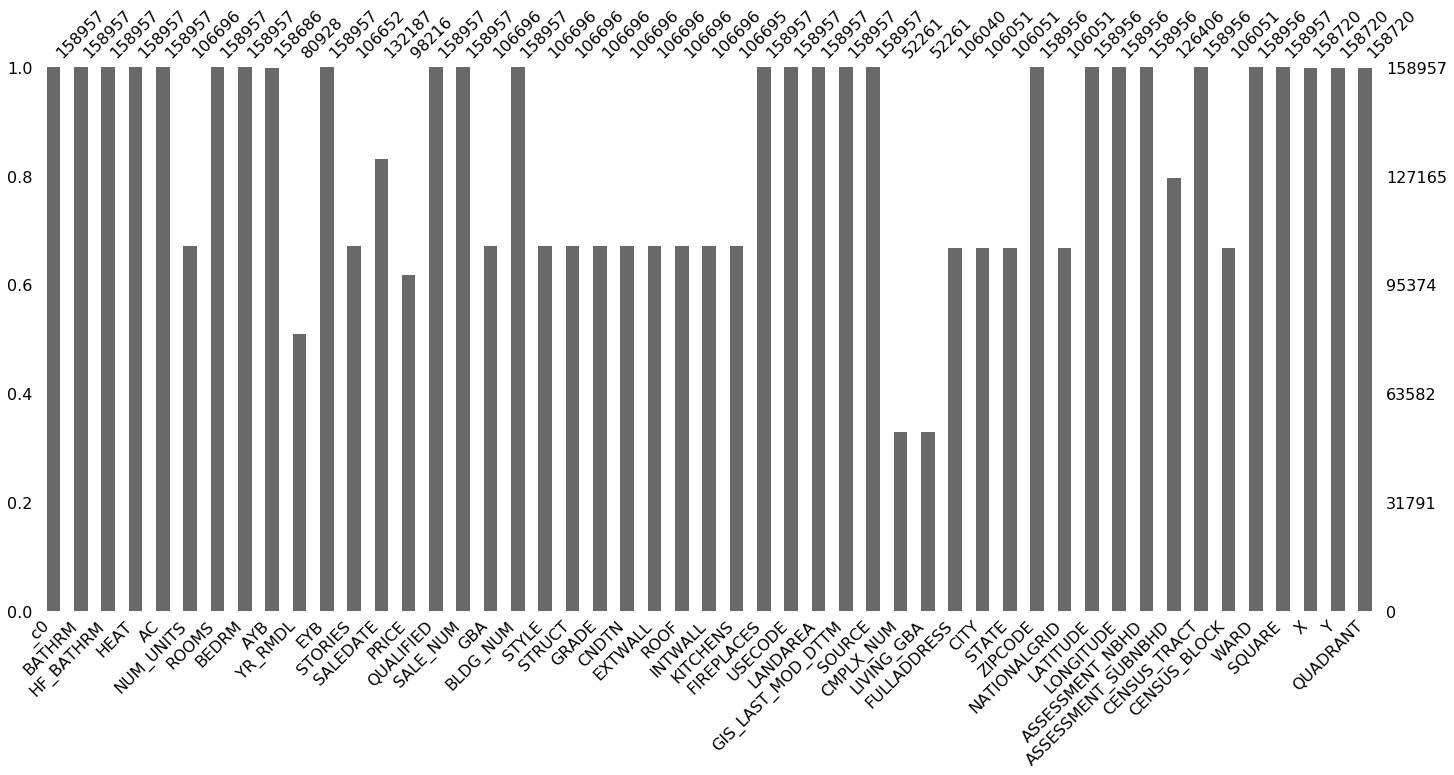

In [12]:
# barchart of how many cells have data in them
msno.bar(py_df)

A lot of the data is missing, around 40% for several categories.

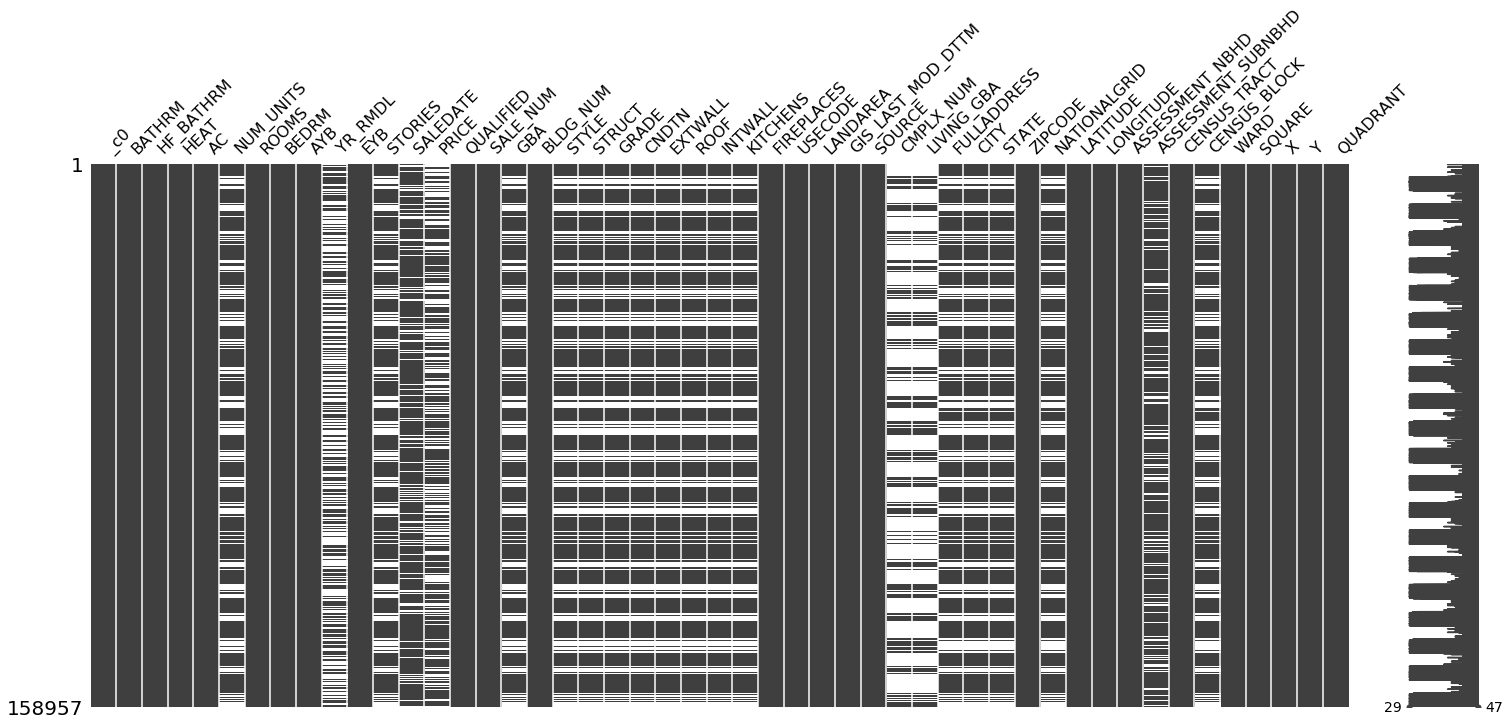

In [13]:
# How do NULLs propogate throughout the dataset?
msno.matrix(py_df)

Nulls seem to be tied to property type. 
Lets see what happens when they are dropped.

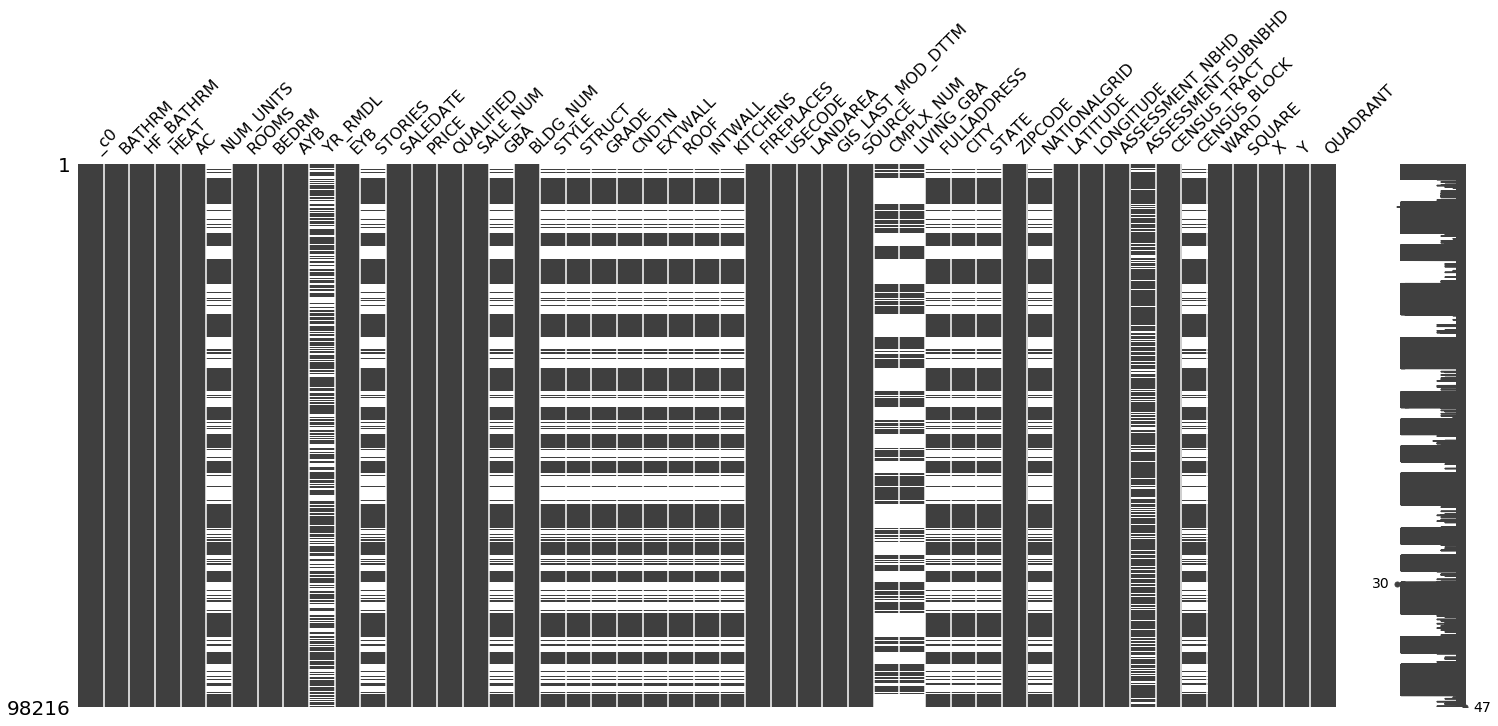

In [16]:
py_df_new = df.where(~F.col("PRICE").isNull()).toPandas()

msno.matrix(py_df_new)

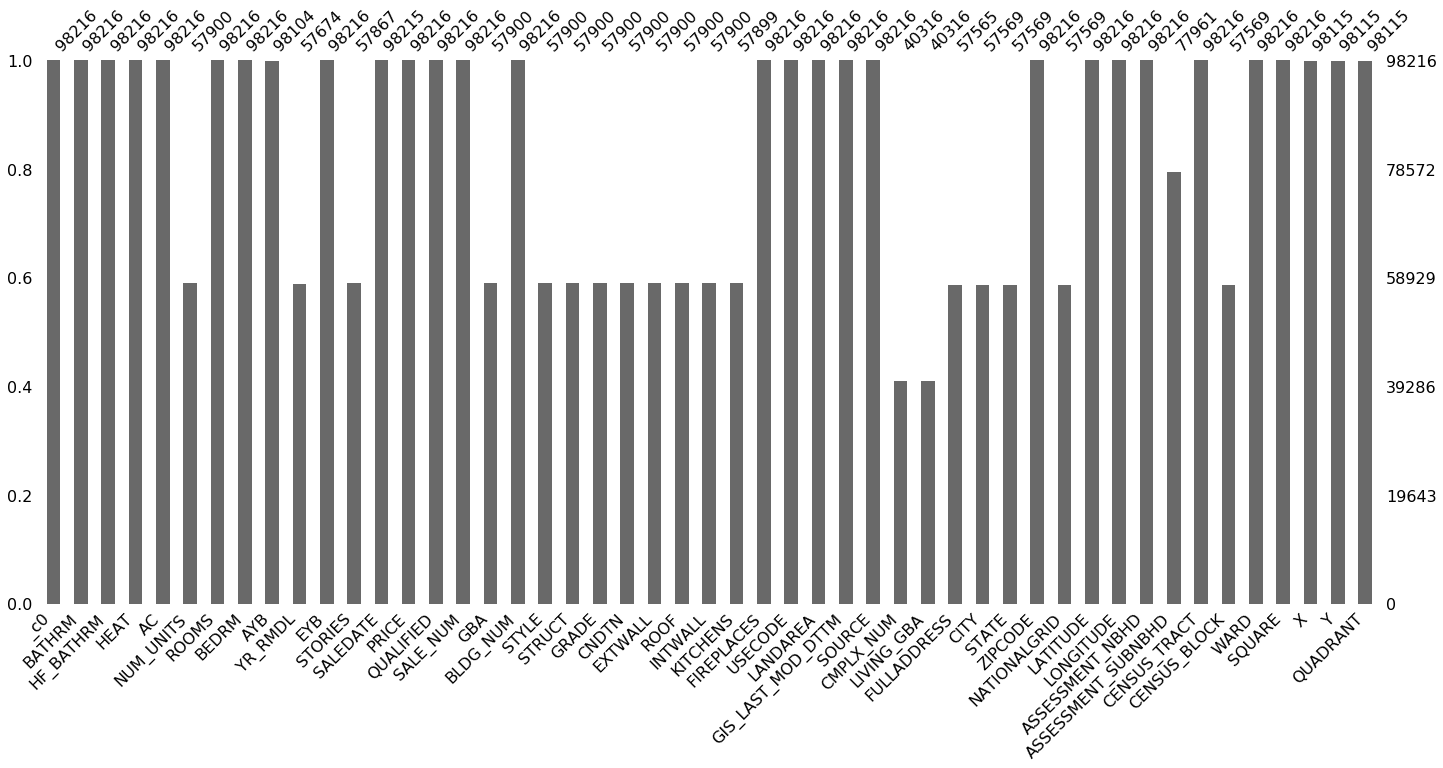

In [24]:
msno.bar(py_df_new)

In [17]:
df = df.where(~F.col("PRICE").isNull())
# we good

### Incorporating Census data into cleaned data

In [18]:
censusdata = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load(data + "raw_census_tracts_in_2010.csv")
censusdata.printSchema()

root
 |-- OBJECTID: integer (nullable = true)
 |-- TRACT: integer (nullable = true)
 |-- GEOID: long (nullable = true)
 |-- P0010001: integer (nullable = true)
 |-- P0010002: integer (nullable = true)
 |-- P0010003: integer (nullable = true)
 |-- P0010004: integer (nullable = true)
 |-- P0010005: integer (nullable = true)
 |-- P0010006: integer (nullable = true)
 |-- P0010007: integer (nullable = true)
 |-- P0010008: integer (nullable = true)
 |-- OP000001: integer (nullable = true)
 |-- OP000002: integer (nullable = true)
 |-- OP000003: integer (nullable = true)
 |-- OP000004: integer (nullable = true)
 |-- P0020002: integer (nullable = true)
 |-- P0020005: integer (nullable = true)
 |-- P0020006: integer (nullable = true)
 |-- P0020007: integer (nullable = true)
 |-- P0020008: integer (nullable = true)
 |-- P0020009: integer (nullable = true)
 |-- P0020010: integer (nullable = true)
 |-- OP00005: integer (nullable = true)
 |-- OP00006: integer (nullable = true)
 |-- OP00007: integer 

In [ ]:
censusdata.show(5)

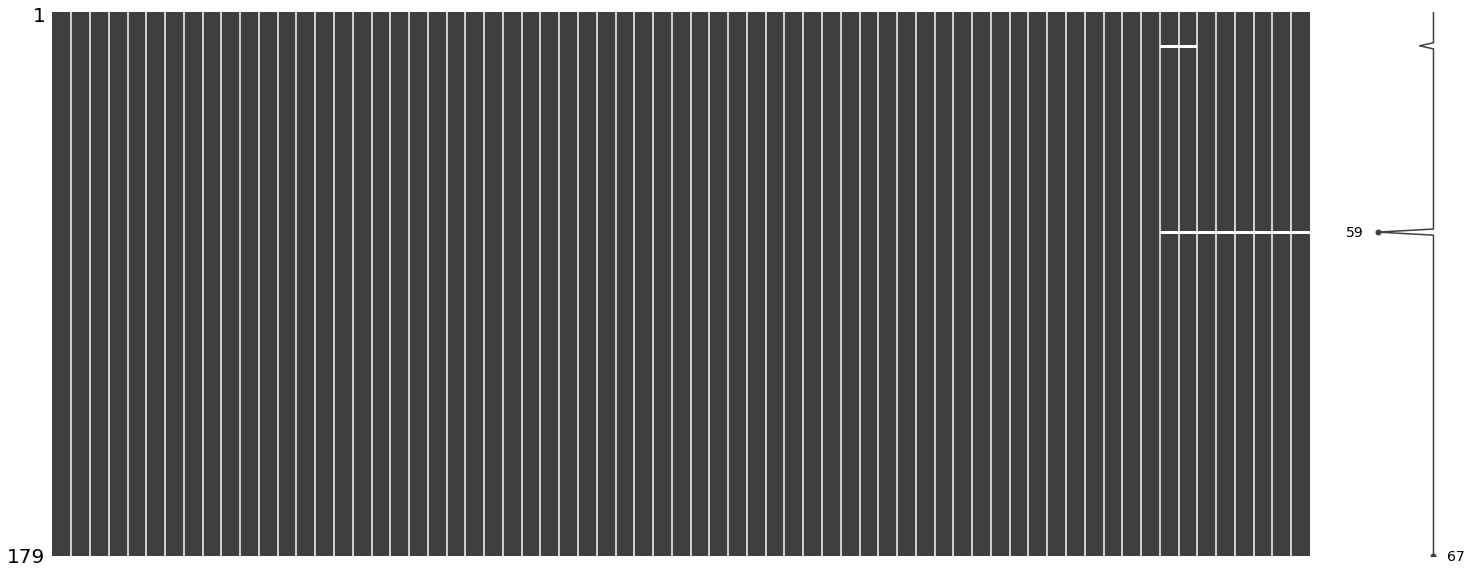

In [19]:
# NULLs here too?
py_censusdata = censusdata.toPandas()
msno.matrix(py_censusdata)

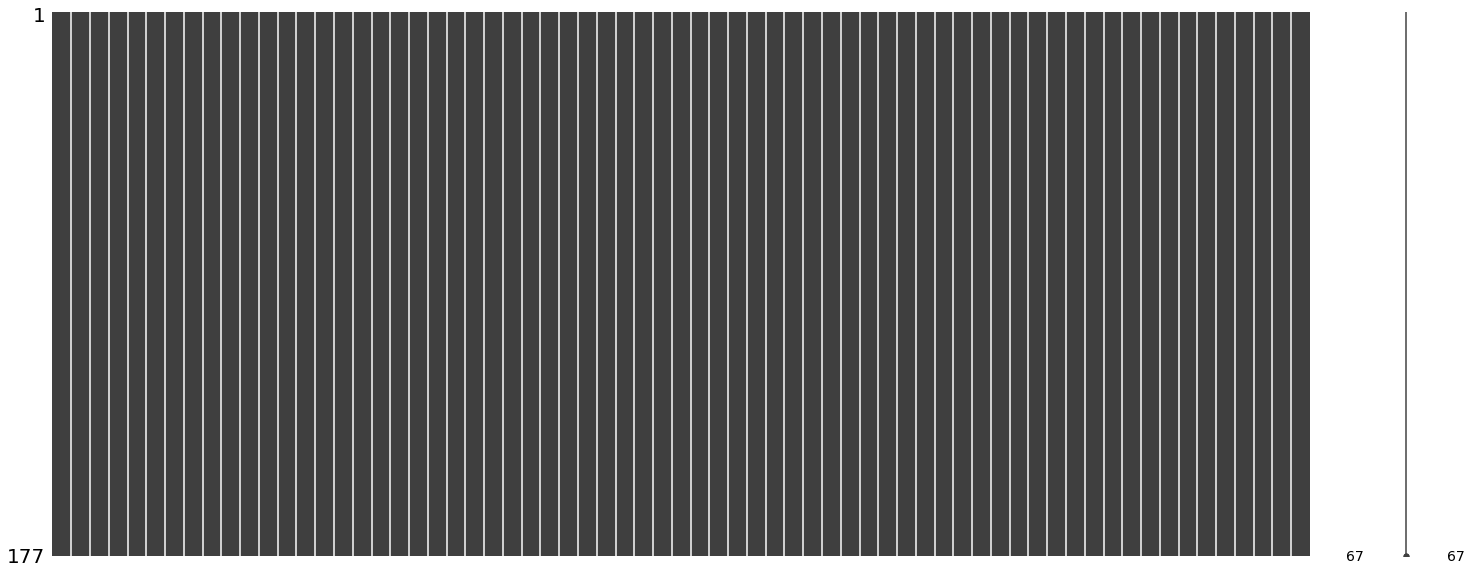

In [21]:
# whoops, step#2
censusdata = censusdata.na.drop()
py_censusdata = censusdata.toPandas()
msno.matrix(py_censusdata)

In [22]:
df.createOrReplaceTempView("df")
censusdata.createOrReplaceTempView("censusdata")

In [23]:
dfcd = df.join(censusdata, 
            on = df["CENSUS_TRACT"] == censusdata['TRACT'],
            how = "left")

In [24]:
dfcd.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- BATHRM: integer (nullable = true)
 |-- HF_BATHRM: integer (nullable = true)
 |-- HEAT: string (nullable = true)
 |-- AC: string (nullable = true)
 |-- NUM_UNITS: double (nullable = true)
 |-- ROOMS: integer (nullable = true)
 |-- BEDRM: integer (nullable = true)
 |-- AYB: double (nullable = true)
 |-- YR_RMDL: double (nullable = true)
 |-- EYB: integer (nullable = true)
 |-- STORIES: double (nullable = true)
 |-- SALEDATE: timestamp (nullable = true)
 |-- PRICE: double (nullable = true)
 |-- QUALIFIED: string (nullable = true)
 |-- SALE_NUM: integer (nullable = true)
 |-- GBA: double (nullable = true)
 |-- BLDG_NUM: integer (nullable = true)
 |-- STYLE: string (nullable = true)
 |-- STRUCT: string (nullable = true)
 |-- GRADE: string (nullable = true)
 |-- CNDTN: string (nullable = true)
 |-- EXTWALL: string (nullable = true)
 |-- ROOF: string (nullable = true)
 |-- INTWALL: string (nullable = true)
 |-- KITCHENS: double (nullable = true)
 

In [25]:
dfcd.show()

+------+------+---------+-------------+---+---------+-----+-----+------+-------+----+-------+-------------------+--------+---------+--------+------+--------+-------+-------------+-------+-------+------------+--------+--------+--------+----------+-------+--------+-------------------+-----------+---------+----------+--------------------+----------+-----+-------+------------------+------------------+------------------+----------------+--------------------+------------+------------+------+------+------------------+------------------+--------+--------+-----+-----------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-----

#### Summary of the column PRICE using describe()

In [10]:
df.describe(['PRICE']).show()

+-------+-----------------+
|summary|            PRICE|
+-------+-----------------+
|  count|            98216|
|   mean|931351.5949336156|
| stddev|7061324.955611982|
|    min|              1.0|
|    max|     1.37427545E8|
+-------+-----------------+



#### Use data after Year 2000

In [11]:
from pyspark.sql import functions as F

df = df.where(F.year("SALEDATE") >= 2000)
df.describe(['PRICE']).show()

+-------+------------------+
|summary|             PRICE|
+-------+------------------+
|  count|             89459|
|   mean|1002258.2660660191|
| stddev| 7394765.238397817|
|    min|               1.0|
|    max|      1.37427545E8|
+-------+------------------+



#### Use statistics methods to exclude the outliers

In [12]:
from pyspark.sql.functions import mean, stddev

# Calculate values used for outlier filtering
mean_val = df.agg({'PRICE': 'mean'}).collect()[0][0]
stddev_val = df.agg({'PRICE': 'stddev'}).collect()[0][0]

# Create three standard deviation (μ ± 3σ) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
df = df.where((df['PRICE'] < hi_bound) & (df['PRICE'] > low_bound))

In [13]:
df.describe(['PRICE']).show()

+-------+-----------------+
|summary|            PRICE|
+-------+-----------------+
|  count|            89042|
|   mean|560489.6947395611|
| stddev|624990.3158814522|
|    min|          10011.0|
|    max|            2.2E7|
+-------+-----------------+



#### Average price grouped by rooms?

In [14]:
df.groupBy("ROOMS").avg("PRICE").orderBy("ROOMS").show()

+-----+------------------+
|ROOMS|        avg(PRICE)|
+-----+------------------+
|    0|  684631.224489796|
|    1| 228049.9365079365|
|    2|279625.25104836456|
|    3| 414523.0071892925|
|    4| 473916.2436598379|
|    5|503497.99006314046|
|    6| 478809.9857295956|
|    7| 559164.8552504351|
|    8| 691010.9208091772|
|    9| 867727.3081621322|
|   10| 977329.9130028064|
|   11|1259696.8744473916|
|   12| 964828.6670822942|
|   13|1813800.0506666666|
|   14|1565844.9666666666|
|   15|2001627.4258064516|
|   16| 642821.5985815603|
|   17| 3316535.714285714|
|   18|1560517.5409836066|
|   19|3248112.3529411764|
+-----+------------------+
only showing top 20 rows



#### Date range of house

In [15]:
df.selectExpr("min(EYB)", "max(EYB)").show()

+--------+--------+
|min(EYB)|max(EYB)|
+--------+--------+
|    1820|    2018|
+--------+--------+



#### Average price grouped by LAND AREA?

In [16]:
df.groupBy("LANDAREA").avg("PRICE").orderBy("LANDAREA").show()

+--------+------------------+
|LANDAREA|        avg(PRICE)|
+--------+------------------+
|       0| 763316.4838709678|
|       1|          463500.0|
|       2|          635000.0|
|       3|          321350.0|
|       4| 274342.2727272727|
|       5|143411.76923076922|
|       6|          270443.0|
|       7| 370583.1818181818|
|       8|        449519.475|
|       9|498448.79347826086|
|      10| 455871.5367647059|
|      11| 515082.4175824176|
|      12| 734490.4761904762|
|      13| 718138.0303030303|
|      14| 663965.5416666666|
|      15|          813650.0|
|      16|          949000.0|
|      17|         1156237.5|
|      18|         665996.25|
|      19| 650742.1052631579|
+--------+------------------+
only showing top 20 rows



#### Average price grouped by Source of house and Condition?

In [17]:
from pyspark.sql import functions as F

df.groupBy("SOURCE","CNDTN").avg("PRICE").orderBy(F.desc("avg(PRICE)")).show()

+-----------+---------+------------------+
|     SOURCE|    CNDTN|        avg(PRICE)|
+-----------+---------+------------------+
|Residential|  Default|3024666.6666666665|
|Residential|Excellent|1246668.5170842824|
|Residential|Very Good|  949425.826893354|
|Residential|     Good| 682519.7764780138|
|Residential|     Poor| 524901.0975609756|
|Condominium|     null| 473028.5306718598|
|Residential|     Fair|453501.43961352657|
|Residential|  Average|423817.82872729143|
+-----------+---------+------------------+



#### Average price grouped by Quadrant of house location in washington DC city?

In [18]:
df.groupBy("QUADRANTå").avg("PRICE").show()

+---------+------------------+
|QUADRANTå|        avg(PRICE)|
+---------+------------------+
|     null|482521.27777777775|
|       NE|416370.27716197324|
|       SE| 388392.5239282499|
|       NW| 673368.2134608723|
|       SW|367933.23506133753|
+---------+------------------+



#### How many house types are there based on Structure?

In [19]:
df.select("STRUCT").distinct().count()

9

In [20]:
df.groupBy("STRUCT", "STYLE").count().orderBy("STYLE").show()

+-------------+---------------+-----+
|       STRUCT|          STYLE|count|
+-------------+---------------+-----+
|         null|           null|37999|
|   Row Inside|        1 Story|   27|
|Semi-Detached|        1 Story|   45|
|       Single|        1 Story| 1637|
|      Row End|        1 Story|   15|
|        Multi|        1 Story|    6|
|       Single|  1.5 Story Fin|  934|
|   Row Inside|  1.5 Story Fin|   14|
|      Row End|  1.5 Story Fin|    2|
|Semi-Detached|  1.5 Story Fin|   27|
|        Multi|  1.5 Story Fin|    1|
|       Single|1.5 Story Unfin|   36|
|      Row End|1.5 Story Unfin|    1|
|Semi-Detached|1.5 Story Unfin|    4|
|   Row Inside|1.5 Story Unfin|    2|
|        Multi|1.5 Story Unfin|    4|
|     Town End|        2 Story|   56|
|Semi-Detached|        2 Story| 6554|
|      Default|        2 Story|    2|
|       Single|        2 Story| 7797|
+-------------+---------------+-----+
only showing top 20 rows



#### Comparison of house price based on year and strcuture type

In [21]:
df.groupBy("STRUCT").avg("PRICE").show()

+-------------+------------------+
|       STRUCT|        avg(PRICE)|
+-------------+------------------+
|  Town Inside|399895.26086956525|
|         null| 473028.5306718598|
|        Multi| 418598.8694794953|
|Semi-Detached| 418765.7134171618|
|      Row End| 609573.3047619048|
|   Row Inside| 601713.3452754782|
|      Default|         3241500.0|
|     Town End| 463481.8181818182|
|       Single| 818776.3047639765|
+-------------+------------------+



## Visualization

### Find the trends for property sales by year. 

#### analysis the total sales count, average price and totoal sales value by each year. (Exclude 2007 and 2015 which contains invalid data)

In [23]:
from pyspark.sql import functions as F
#exclude 2007 and 2015 data since they are outliers
sales_for_each_year = df.groupBy(F.year("SALEDATE").alias("Year"))\
                        .agg(F.count("ID").alias("sales_count"),F.avg("PRICE").alias("avg_price"))\
                        .where(F.col("Year") >= 2000)\
                        .where(F.col("Year") <= 2017)\
                        .orderBy(F.desc("Year"))
sales_for_each_year.show()

+----+-----------+------------------+
|Year|sales_count|         avg_price|
+----+-----------+------------------+
|2017|       9774| 754785.6731123389|
|2016|       8095| 648859.0569487337|
|2015|       7306| 640757.4742677251|
|2014|       6576| 636613.0003041363|
|2013|       6014| 603202.4634186897|
|2012|       4793| 554353.2443146255|
|2011|       4023| 533096.3475018643|
|2010|       4143| 562119.6722181994|
|2009|       3825|483166.16104575165|
|2008|       3350|512125.38417910447|
|2007|       4093| 502480.5138040557|
|2006|       3779|487862.33897856576|
|2005|       4250|498257.22329411766|
|2004|       3665|403397.68649386085|
|2003|       2997| 357844.8014681348|
|2002|       2664|304425.33295795793|
|2001|       2407| 277478.5400914001|
|2000|       2160| 239973.8361111111|
+----+-----------+------------------+



In [24]:
py_dc_data = sales_for_each_year.toPandas()
py_dc_data.head()

,Year,sales_count,avg_price
0,2017,9774,754785.673112
1,2016,8095,648859.056949
2,2015,7306,640757.474268
3,2014,6576,636613.000304
4,2013,6014,603202.463419


#### Use *matplotlib* for plotting

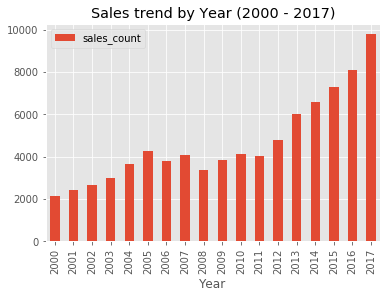

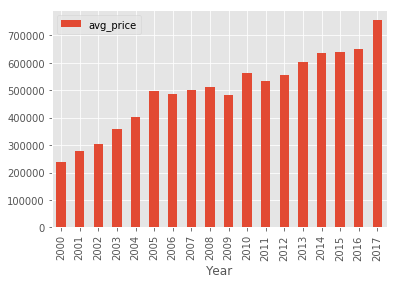

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df1 = py_dc_data.set_index('Year')
df1[["sales_count" ]].plot.bar().invert_xaxis()
plt.title('Sales trend by Year (2000 - 2017)')
df1[["avg_price" ]].plot.bar().invert_xaxis()

In [26]:
sales_for_each_month = df.groupBy(F.month("SALEDATE").alias("Month"))\
                        .agg(F.count("ID").alias("sales_count"),F.avg("PRICE").alias("avg_price"))\
                        .where(F.col("Month") >= 1)\
                        .orderBy(F.asc("Month"))
sales_for_each_month.show()

+-----+-----------+-----------------+
|Month|sales_count|        avg_price|
+-----+-----------+-----------------+
|    1|       6236|537387.7825529185|
|    2|       5402|521548.2558311736|
|    3|       7201|520568.9136231079|
|    4|       7459|553036.7120257408|
|    5|       8703|599319.2018844077|
|    6|       9136|678162.3434763573|
|    7|       8490|580905.1861012956|
|    8|       7903|545420.9391370366|
|    9|       7062|512727.2972245823|
|   10|       7256|528273.8350330761|
|   11|       6712|546498.6838498212|
|   12|       7482|546485.5312750601|
+-----+-----------+-----------------+



#### Find the trends for property sales by month.

Text(0.5, 1.0, 'Sales trend by month')

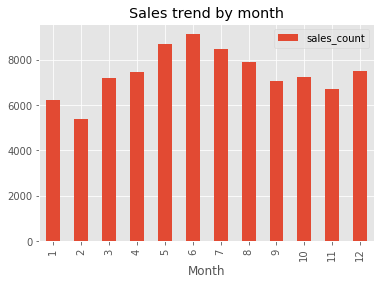

In [27]:
py_dc_data3 = sales_for_each_month.toPandas()
py_dc_data3.head()
df3 = py_dc_data3.set_index('Month')
df3[["sales_count"]].plot.bar()
plt.title('Sales trend by month')

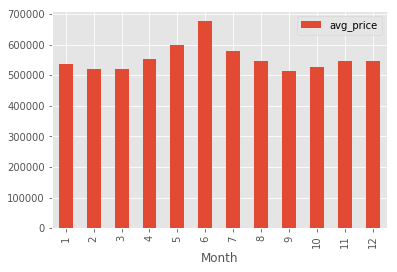

In [28]:
df3[["avg_price"]].plot.bar()

#### Average sales price per ward

In [29]:
sales_each_ward = df.groupBy(F.col("WARD"))\
                        .agg(F.avg("PRICE").alias("avg_price"))\
                        .where(F.col("WARD") != 'null')\
                        .orderBy(F.desc("avg_price"))
sales_each_ward.show()

+------+------------------+
|  WARD|         avg_price|
+------+------------------+
|Ward 3| 839904.3091846758|
|Ward 2| 727248.6242754136|
|Ward 1| 598745.9872033899|
|Ward 6|  556323.498071552|
|Ward 4| 531791.3386896222|
|Ward 5|416043.14266702154|
|Ward 8|279133.00363133324|
|Ward 7| 247770.4354974199|
+------+------------------+



In [30]:
py_dc_data2 = sales_each_ward.toPandas()
py_dc_data2.head()

,WARD,avg_price
0,Ward 3,839904.309185
1,Ward 2,727248.624275
2,Ward 1,598745.987203
3,Ward 6,556323.498072
4,Ward 4,531791.338690


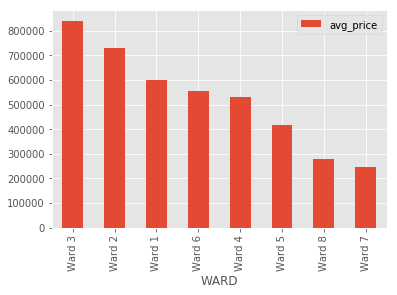

In [31]:
df2 = py_dc_data2.set_index('WARD')
df2[["avg_price"]].plot.bar()

Ward 3 has most avg_price in D.C.

## Sampling & Scatterplot
sample 5% of the data to plot a scatterplot:

In [32]:
df_sample = df.where(F.year("SALEDATE") == 2017).sample(withReplacement = False, fraction = 0.05, seed = 8)

# Convert to Pandas
py_df_sample = df_sample.toPandas()

py_df_sample.head()

,ID,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,...,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANTå
0,158248,1,0,Ht Pump,Y,NaN,4,2,2006.0,2006.0,...,-77.018312,Old City 2,040 B Old City 2,4802.0,None,Ward 6,0514,-77.018315,38.905417,NW
1,113494,1,0,Forced Air,Y,NaN,5,2,1959.0,NaN,...,-77.080883,Glover Park,None,702.0,None,Ward 3,1708,-77.080885,38.923855,NW
2,72254,3,1,Forced Air,Y,1.0,8,3,2017.0,NaN,...,-76.998763,Brookland,007 B Brookland,9509.0,009509 3004,Ward 5,3788,-76.998047,38.949595,NE
3,158565,2,1,Ht Pump,Y,NaN,4,2,2013.0,NaN,...,-77.025373,Central-tri 3,None,5800.0,None,Ward 2,0374,-77.025376,38.900443,NW
4,123020,1,0,Forced Air,Y,NaN,3,1,1930.0,2017.0,...,-76.989037,Trinidad,052 A Trinidad,8802.0,None,Ward 5,4059,-76.989040,38.906422,NE


Draw plot on housing sales count by location

No handles with labels found to put in legend.


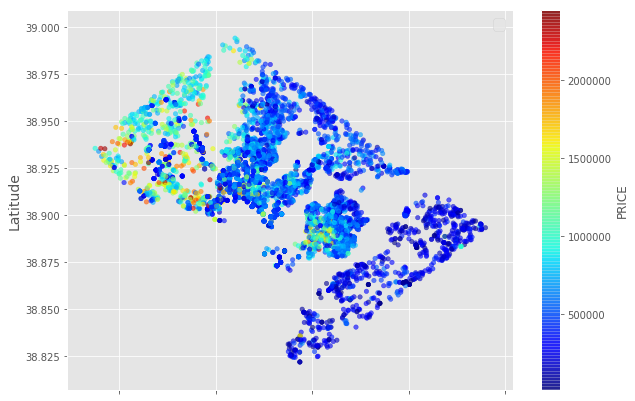

In [289]:
py_df_sample.plot(kind="scatter", x="LONGITUDE", y="LATITUDE",
    c="PRICE", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.6, figsize=(10,7),
)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)
plt.show()

Compare with Washington D.C Map

<img src="https://raw.githubusercontent.com/elieric/is843/master/DC-Ward-Public-Trans.jpg" width="300" align="left"/>

### Regressions

#### Preparing Data

In [19]:
df.columns

['_c0',
 'BATHRM',
 'HF_BATHRM',
 'HEAT',
 'AC',
 'NUM_UNITS',
 'ROOMS',
 'BEDRM',
 'AYB',
 'YR_RMDL',
 'EYB',
 'STORIES',
 'SALEDATE',
 'PRICE',
 'QUALIFIED',
 'SALE_NUM',
 'GBA',
 'BLDG_NUM',
 'STYLE',
 'STRUCT',
 'GRADE',
 'CNDTN',
 'EXTWALL',
 'ROOF',
 'INTWALL',
 'KITCHENS',
 'FIREPLACES',
 'USECODE',
 'LANDAREA',
 'GIS_LAST_MOD_DTTM',
 'SOURCE',
 'CMPLX_NUM',
 'LIVING_GBA',
 'FULLADDRESS',
 'CITY',
 'STATE',
 'ZIPCODE',
 'NATIONALGRID',
 'LATITUDE',
 'LONGITUDE',
 'ASSESSMENT_NBHD',
 'ASSESSMENT_SUBNBHD',
 'CENSUS_TRACT',
 'CENSUS_BLOCK',
 'WARD',
 'SQUARE',
 'X',
 'Y',
 'QUADRANT']

In [31]:
dc = df.toPandas()

In [32]:
import pandas as pd
dc = pd.get_dummies(dc, prefix='HEAT_', columns=['HEAT'])
dc = pd.get_dummies(dc, prefix='AC_', columns=['AC'])
dc = pd.get_dummies(dc, prefix='QUALIFIED_', columns=['QUALIFIED'])
dc = pd.get_dummies(dc, prefix='STYLE_', columns=['STYLE'])
dc = pd.get_dummies(dc, prefix='STRUCT_', columns=['STRUCT'])
dc = pd.get_dummies(dc, prefix='GRADE_', columns=['GRADE'])
dc = pd.get_dummies(dc, prefix='CNDTN_', columns=['CNDTN'])
dc = pd.get_dummies(dc, prefix='EXTWALL_', columns=['EXTWALL'])
dc = pd.get_dummies(dc, prefix='ROOF_', columns=['ROOF'])
dc = pd.get_dummies(dc, prefix='INTWALL_', columns=['INTWALL'])
dc = pd.get_dummies(dc, prefix='SOURCE_', columns=['SOURCE'])
dc = pd.get_dummies(dc, prefix='WARD_', columns=['WARD'])

In [34]:
print(dc.columns)

Index(['_c0', 'BATHRM', 'HF_BATHRM', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB',
       'YR_RMDL', 'EYB', 'STORIES',
       ...
       'SOURCE__Condominium', 'SOURCE__Residential', 'WARD__Ward 1',
       'WARD__Ward 2', 'WARD__Ward 3', 'WARD__Ward 4', 'WARD__Ward 5',
       'WARD__Ward 6', 'WARD__Ward 7', 'WARD__Ward 8'],
      dtype='object', length=164)


In [37]:
X = dc[['BATHRM', 'HF_BATHRM', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB',
       'YR_RMDL', 'EYB', 'STORIES', 'SALE_NUM',
       'GBA', 'BLDG_NUM', 'KITCHENS', 'FIREPLACES', 'USECODE', 'LANDAREA',
         'LIVING_GBA',
       'ZIPCODE', 'LATITUDE', 'LONGITUDE',
       'CENSUS_TRACT', 'HEAT__Air Exchng', 'HEAT__Air-Oil',
       'HEAT__Elec Base Brd', 'HEAT__Electric Rad', 'HEAT__Evp Cool',
       'HEAT__Forced Air', 'HEAT__Gravity Furnac', 'HEAT__Hot Water Rad',
       'HEAT__Ht Pump', 'HEAT__Ind Unit', 'HEAT__No Data',
       'HEAT__Wall Furnace', 'HEAT__Warm Cool', 'HEAT__Water Base Brd',
       'AC__0', 'AC__N', 'AC__Y', 'QUALIFIED__Q', 'QUALIFIED__U',
       'STYLE__1 Story', 'STYLE__1.5 Story Fin', 'STYLE__1.5 Story Unfin',
       'STYLE__2 Story', 'STYLE__2.5 Story Fin', 'STYLE__2.5 Story Unfin',
       'STYLE__3 Story', 'STYLE__3.5 Story Fin', 'STYLE__3.5 Story Unfin',
       'STYLE__4 Story', 'STYLE__4.5 Story Fin', 'STYLE__4.5 Story Unfin',
       'STYLE__Bi-Level', 'STYLE__Default', 'STYLE__Outbuildings',
       'STYLE__Split Foyer', 'STYLE__Split Level', 'STYLE__Vacant',
       'STRUCT__Default', 'STRUCT__Multi', 'STRUCT__Row End',
       'STRUCT__Row Inside', 'STRUCT__Semi-Detached', 'STRUCT__Single',
       'STRUCT__Town End', 'STRUCT__Town Inside', 'GRADE__Above Average',
       'GRADE__Average', 'GRADE__Excellent', 'GRADE__Exceptional-A',
       'GRADE__Exceptional-B', 'GRADE__Exceptional-C',
       'GRADE__Exceptional-D', 'GRADE__Fair Quality',
       'GRADE__Good Quality', 'GRADE__Low Quality', 'GRADE__No Data',
       'GRADE__Superior', 'GRADE__Very Good', 'CNDTN__Average',
       'CNDTN__Default', 'CNDTN__Excellent', 'CNDTN__Fair', 'CNDTN__Good',
       'CNDTN__Poor', 'CNDTN__Very Good', 'EXTWALL__Adobe',
       'EXTWALL__Aluminum', 'EXTWALL__Brick Veneer',
       'EXTWALL__Brick/Siding', 'EXTWALL__Brick/Stone',
       'EXTWALL__Brick/Stucco', 'EXTWALL__Common Brick',
       'EXTWALL__Concrete', 'EXTWALL__Concrete Block', 'EXTWALL__Default',
       'EXTWALL__Face Brick', 'EXTWALL__Hardboard',
       'EXTWALL__Metal Siding', 'EXTWALL__Plywood', 'EXTWALL__SPlaster',
       'EXTWALL__Shingle', 'EXTWALL__Stone', 'EXTWALL__Stone Veneer',
       'EXTWALL__Stone/Siding', 'EXTWALL__Stone/Stucco',
       'EXTWALL__Stucco', 'EXTWALL__Stucco Block',
       'EXTWALL__Vinyl Siding', 'EXTWALL__Wood Siding', 'ROOF__Built Up',
       'ROOF__Clay Tile', 'ROOF__Comp Shingle', 'ROOF__Composition Ro',
       'ROOF__Concrete', 'ROOF__Concrete Tile', 'ROOF__Metal- Cpr',
       'ROOF__Metal- Pre', 'ROOF__Metal- Sms', 'ROOF__Neopren',
       'ROOF__Shake', 'ROOF__Shingle', 'ROOF__Slate', 'ROOF__Typical',
       'ROOF__Water Proof', 'ROOF__Wood- FS', 'INTWALL__Carpet',
       'INTWALL__Ceramic Tile', 'INTWALL__Default', 'INTWALL__Hardwood',
       'INTWALL__Hardwood/Carp', 'INTWALL__Lt Concrete',
       'INTWALL__Parquet', 'INTWALL__Resiliant', 'INTWALL__Terrazo',
       'INTWALL__Vinyl Comp', 'INTWALL__Vinyl Sheet',
       'INTWALL__Wood Floor', 'SOURCE__Condominium',
       'SOURCE__Residential', 'WARD__Ward 1', 'WARD__Ward 2',
       'WARD__Ward 3', 'WARD__Ward 4', 'WARD__Ward 5', 'WARD__Ward 6',
       'WARD__Ward 7', 'WARD__Ward 8']]

y = dc["PRICE"]

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8 , random_state=100)

#### Correlation matrix of all columns

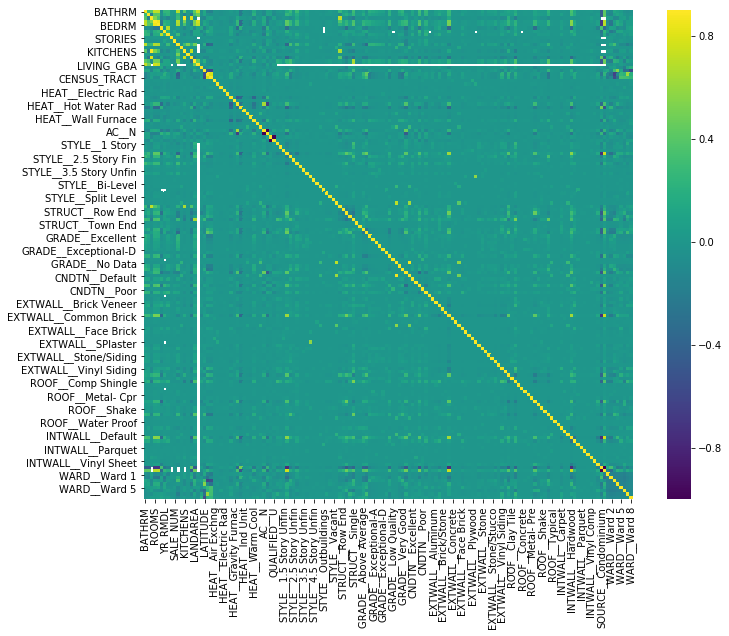

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
corrmat = X_train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True,cmap = "viridis")
plt.show()